In [1]:
import os
pretrain_path = '/data/qingsong/pretrain'

from transformers import CLIPProcessor
import torch
processor = CLIPProcessor.from_pretrained(os.path.join(pretrain_path, 'clip-vit-base-patch32'))

import argparse
swiss_args = argparse.Namespace(
    num_layers=12,
    vocab_size=1,
    hidden_size=768,
    num_attention_heads=12,
    hidden_dropout=0.,
    attention_dropout=0.,
    in_channels=3,
    image_size=[224, 224],
    patch_size=32,
    pre_len=1,
    post_len=0,
    old_image_size=[224, 224],
    old_pre_len=1,
    old_post_len=0,
    inner_hidden_size=None,
    hidden_size_per_attention_head=None,
    checkpoint_activations=True,
    checkpoint_num_layers=1,
    sandwich_ln=False,
    post_ln=False,
    model_parallel_size=1,
    world_size=1,
    rank=0,
    num_classes=1000,
    text_num_layers=12,
    text_hidden_size=512,
    text_num_attention_heads=8,
    text_vocab_size=49408,
    text_max_sequence_length=77,
    load='/data/qingsong/pretrain/swiss-clip',
    logit_scale_init_value=2.6592,
    projection_dim=512,
    mode='inference'
    )

import os
import torch
init_method = 'tcp://'
master_ip = os.getenv('MASTER_ADDR', '127.0.0.1')
master_port = os.getenv('MASTER_PORT', '12468')
init_method += master_ip + ':' + master_port
torch.distributed.init_process_group(
        backend='nccl',
        world_size=swiss_args.world_size, rank=swiss_args.rank, init_method=init_method)
import SwissArmyTransformer.mpu as mpu
mpu.initialize_model_parallel(swiss_args.model_parallel_size)
from clip_model import CLIP
from SwissArmyTransformer.training.deepspeed_training import load_checkpoint
swiss_model = CLIP(swiss_args)
load_checkpoint(swiss_model, swiss_args)
model = swiss_model.cuda()

> initializing model parallel with size 1
global rank 0 is loading checkpoint /data/qingsong/pretrain/swiss-clip/1/mp_rank_00_model_states.pt
  successfully loaded /data/qingsong/pretrain/swiss-clip/1/mp_rank_00_model_states.pt


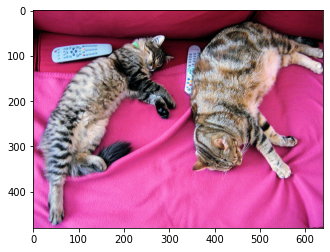

In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)
expanded_mask = inputs['attention_mask'][:, None, None, :].expand(2, 1, 7, 7).to(torch.float)

In [3]:
with torch.no_grad():
    image_position_ids = torch.cat([torch.arange(50)[None,]])
    text_position_ids = torch.cat([torch.arange(7)[None,], torch.arange(7)[None,]])
    encoded_input = {'text_attention_mask':expanded_mask, 'image_input_ids':torch.zeros(1, 1).long(), 'image_position_ids':image_position_ids, 'image':inputs['pixel_values'], 'text_input_ids':inputs['input_ids'], 'text_position_ids':text_position_ids}
    model = model.cuda()
    encoded_input = {k:v.cuda() for k,v in encoded_input.items()}
    image_embeds, text_embeds, logits_per_text, logits_per_image = model(offline=True, **encoded_input)
    logits_per_text = logits_per_text.cpu()
    print(logits_per_text)

[2022-04-12 09:38:46,271] [INFO] [checkpointing.py:547:forward] Activation Checkpointing Information
[2022-04-12 09:38:46,272] [INFO] [checkpointing.py:548:forward] ----Partition Activations False, CPU CHECKPOINTING False
[2022-04-12 09:38:46,273] [INFO] [checkpointing.py:551:forward] ----contiguous Memory Checkpointing False with None total layers
[2022-04-12 09:38:46,274] [INFO] [checkpointing.py:554:forward] ----Synchronization False
[2022-04-12 09:38:46,275] [INFO] [checkpointing.py:555:forward] ----Profiling time in checkpointing False
tensor([[24.5746],
        [19.3080]])
